# The Explainer Notebook

### Structure of this notebook

The notebook consists of XX parts 

__________

# Part 0: Initialization

In [2]:
import requests
from bs4 import BeautifulSoup
from imdb import IMDb
import csv
import json
import pandas as pd
import numpy as np 
import regex as re
from collections import Counter
import heapq
import unicodedata
import networkx as nx 
import community.community_louvain as cl
import community
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from fa2 import ForceAtlas2
from pyvis.network import Network
from tabulate import tabulate

In [12]:
color_palette_cividis = sns.color_palette("cividis", 40)
color_palette_plasma = sns.color_palette("plasma", 40)
color_palette_cividis_reversed = list(reversed(color_palette_cividis))
colorpalette = color_palette_plasma + color_palette_cividis_reversed
two_colors = colorpalette[::8][0:2]
three_ratings_colors = colorpalette[::6][0:3]
three_different_colors = colorpalette[::10][0:3]
genre_colors = colorpalette[::7][0:8]
hex_colors_genre = ['#1d068d', '#6700a7', '#a51f97', '#d3516f', '#f38649', '#fdc427', '#ecd54a', '#bcae6b']

______________

# Part 1: Data 

The data utilized for this project is obtained from various Wikipedia lists encompassing movies across different genres. Although numerous genres are available, this study will concentrate on seven specific movie genres to ensure manageability:

<div style="text-align: center;">
    <a href="https://en.wikipedia.org/wiki/Lists_of_action_films">Action</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_adventure_films">Adventure</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_comedy_films">Comedy</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_fantasy_films">Fantasy</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_horror_films">Horror</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_science_fiction_films">Science Fiction</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_thriller_films">Thriller</a>
</div>

The corresponding Wikipedia lists can be accessed through the provided links. We have extracted movie data spanning the years 2000 to 2023, encompassing essential information such as movie *title*, *director*, *cast*, *release year*, *genre*, and *country of origin*. To accomplish this, we employed `Beautiful Soup` for web scraping, enabling us to extract comprehensive tables containing movie details for each genre and year.

Additionally, for the purpose of gathering movie plots, we identified and saved the hyperlinks leading to individual movie pages. These hyperlinks were subsequently employed in Wikipedia API `requests` to retrieve and scrape the movie plots. Furthermore, we utilized the `IMDb` Module in Python to collect movie *ratings*, precise *release dates*, and *box office* information. These combined efforts yielded the following dataset:

<style>
table {
  margin: 0 auto;
}
</style>
| Attribute         | Type           | Description                                                    |
|-------------------|----------------|----------------------------------------------------------------|
| Title             | str            | Name of the movies written in the Wikipedia list.              |
| Director          | str            | Director of the movies collected from the Wikipedia list.      |
| Cast              | str            | Casts of the movies collected from the Wikipedia list.         |
| Country           | str            | The origin of the movie.                                       |
| Genre             | float          | The genre of the movie                                         |
| Year              | integer        | The release year of the movie.                                 |
| Hyperlink         | str            | The hyperlink to the Wikipedia page of the movie.              |
| Rating            | float          | The rating of the movie collected using `IMDb` Module.         |
| AirDate           | str            | The release date of the movie collected using `IMDb` Module.   |
| BoxOffice         | integer        | The boxoffice of the movies collected using `IMDb` Module.     |
| Plot              | str            | Plot of Movies.                                                |



In the context of network analysis, each movie will be a node, and connections between movies will be established based on the presence of common actors. This approach allows the network to illustrate the interconnections among movies in terms of shared cast members. As for the NLP part, the *plots* of the movies will be used to analyze the sentiment of the movie plots. Futhermore, the other features will be utilized in the project as attributes to the network and our analysis.

## 1.1: Data Collection of Movies

#### Data for the network analysis

In the following code the list of movies and their corresponding meta data is scraped from the seven different wikipedia pages <a href="https://en.wikipedia.org/wiki/Lists_of_action_films">Action</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_adventure_films">Adventure</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_comedy_films">Comedy</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_fantasy_films">Fantasy</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_horror_films">Horror</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_science_fiction_films">Science Fiction</a> |
    <a href="https://en.wikipedia.org/wiki/Lists_of_thriller_films">Thriller</a> spanning the years 2000 to 2023. 

The data collection process employs `BeautifulSoup` and `HTML` parsing techniques to extract essential information, including tables and metadata related to the movies. Subsequently, this gathered data is stored in a Pandas DataFrame.

In [ ]:
def collect_movies_artist_data(genre: str, year:str, sub_years:list) -> pd.DataFrame:
    """
    Collects movie data from Wikipedia for a specified genre, year, and subyears.

    Args:
    - genre (str): The genre of movies to collect data for.
    - year (str): The main year for which data is collected.
    - sub_years (list): A list of subyears for which data should be collected.

    Returns:
    - pd.DataFrame: A DataFrame containing movie data.

    Example usage:
    collect_movies_artist_data('horror', '2023', ['2023']) 
    """

    titles = []
    directors = []
    casts = []
    countries = []
    all_years = []
    genres = []
    link_refs = []

    # Define the URL based on the genre and year
    if genre == 'horror':
        url = f"https://en.wikipedia.org/wiki/List_of_horror_films_of_{year}"
        sub_years = [year]
    else: 
        url = f"https://en.wikipedia.org/wiki/List_of_{genre}_films_of_the_{year}"

    # Get data using BeautifulSoup and HTML
    wiki_page = requests.get(url)
    soup = BeautifulSoup(wiki_page.text, 'html.parser')

    # Find all tables in the wiki page
    all_tables = soup.find_all('table', {'class':'wikitable'})

    # Iterate through subyears and rows in tables         
    for sub_year_idx, sub_year in enumerate(sub_years):
        for row in all_tables[sub_year_idx].find_all('tr'): 
            columns = row.find_all('td')

            # Extracting the subyear of the tables that are merged and not divided into subtables. 
            if (genre == 'thriller') or (genre == 'fantasy') or (genre=='science_fiction'): 
                if (len(columns)!=0): 
                    if (re.search(r"2\d{3}\n", columns[0].text)):
                        sub_year = columns[0].text[:4]
            
            # Extract data from columns
            if len(columns) >= 4:
                if genre == 'horror' and not (sub_year == '2020' or sub_year == '2021' or sub_year == '2022' or sub_year == '2019'):
                    try: 
                        title = row.find('a').get_text(strip=True)
                    except: 
                        title = row.find('i').get_text(strip=True)
                    director = columns[0].get_text(strip=True)
                    cast_list = columns[1].get_text(strip=True)
                    country = columns[2].get_text(strip=True)
                elif genre == 'comedy' and sub_year=='2007':       
                    title = row.find('a').get_text(strip=True)
                    director = columns[0].get_text(strip=True)
                    cast_list = columns[1].get_text(strip=True)
                    country = columns[2].get_text(strip=True)
                else: 
                    title = columns[0].get_text(strip=True)
                    director = columns[1].get_text(strip=True)
                    cast_list = columns[2].get_text(strip=True)
                    country = columns[3].get_text(strip=True)

                # Get hyperlinks to movie plots
                if genre == 'horror' and not (sub_year == '2020' or sub_year == '2021' or sub_year == '2022' or sub_year == '2019'):
                    first_column = row.find('th')
                else:
                    first_column = row.find('td')

                if first_column: 
                    href_link = first_column.find('a')
                    if href_link:
                        href = href_link.get('href').replace('/wiki/', '')
                    else:
                        href = ''
                else: 
                    href = ''
        
                # Append data to lists
                titles.append(title)
                directors.append(director)
                casts.append(cast_list)
                countries.append(country)
                genres.append(genre)
                all_years.append(sub_year)
                link_refs.append(href)
    
    # Create a DataFrame from collected data
    data = {"Title": titles,
            "Director": directors,
            "Cast": casts,
            "Country": countries,
            "Genre": genres, 
            "Year": all_years, 
            "Hyperref": link_refs}
    
    df = pd.DataFrame(data)
    return df


In [ ]:
# Params for the function defining the genre name, the years and the corresponding subyears for each year, which follows the structure of the corresponding wikipage.
params = {
        "thriller": {"years": ["2020s","2010s", "2000s"],
                "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],[[]]]}, 
        "action": {"years": ["2020s","2010s", "2000s"],
                "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],["2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"]]},             
        "comedy": {"years": ["2020s","2010s", "2000s"],
                "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],["2000", "2001", "2002","2003","2004","2005","2006","2007"]]},
        "adventure": {"years": ["2020s","2010s", "2000s"],
                "sub_years": [["2020", "2021", "2022", "2023"], ["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"], ["2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"]]}, 
        "horror": {"years": ["2020", "2021", "2022", "2010","2011","2012","2013","2014","2015","2016","2017","2018","2019", "2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"], 
                "sub_years": [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]},
        "fantasy": {"years": ["2020s","2010s", "2000s"],
                "sub_years": [[[]],[[]],[[]]]}, 
        "science_fiction": {"years": ["2020s", "2010s", "2000s"],
                "sub_years": [[[]],[[]],[[]]]}, 
        }

# Looping over alle genres, years and subyears. 
data_movie_artist = pd.DataFrame()
for genre in params.keys():
    for years, sub_years in zip(params[genre]["years"],params[genre]["sub_years"]):
        data = collect_movies_artist_data(genre, years, sub_years)
        data_movie_artist = pd.concat([data_movie_artist, data]) 
data_movie_artist = data_movie_artist.reset_index(drop=True)

The outcome of the above code segment is a single DataFrame containing seven variables and encompassing a total of 7,456 movies.

In [3]:
data_movie_artist = pd.read_json('data_movie_artist.json', orient='table')
data_movie_artist.shape

(7456, 7)

In [4]:
data_movie_artist.head(2)

,Title,Director,Cast,Country,Genre,Year,Hyperref
0,365 Days,Barbara BiałowąsTomasz Mandes,"Anna-Maria Sieklucka,Michele Morrone, Bronisła...",Poland,thriller,2020,365_Days_(2020_film)
1,7500,Patrick Vollrath,"Joseph Gordon-Levitt,Aylin Tezel","Germany, Austria, United States",thriller,2020,7500_(film)


In [6]:
data_movie_artist[data_movie_artist.duplicated(subset='Title')].shape

(1507, 7)

## 1.2 Data Cleaning of Movies

The initial step following the data collection of movies from the Wikipedia lists involves data cleaning. We identified and addressed 1,507 duplicates and also handled rows with missing data, such as missing film titles or cast information. This data cleaning step was crucial before obtaining ratings and plots since our aim was to avoid extracting unnecessary data.

Within the following code block, a series of functions inside a class named **DataCleaning** have been implemented to perform various data cleaning operations. These functions are documented to ensure that the reader can understand their purpose and functionality without needing to dive into the code.

After the code block, we will provide an explanation of the rationale behind the choice of each data cleaning operation and its significance in preparing the dataset for subsequent analysis.

In [ ]:
class DataCleaning:
    def __init__(self, dataframe):
        """
        Initializes a DataCleaning instance with a given DataFrame.

        Args:
        - dataframe (pd.DataFrame): The DataFrame containing movie data to be cleaned.
        """
        self.data = dataframe
    
    def clean_text_title_column(self, text):
        """
        Cleans the 'Title' column of the DataFrame by removing unwanted characters and formatting.

        Args:
        - text (str): The text to be cleaned.

        Returns:
        - str: The cleaned text.
        """
        # Remove text within square brackets and parentheses
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r'\(.*?\)', '', text)
        # Replace 
        text = text.replace('!', '')
        text = text.replace('.', '')
        text = text.replace('-', '')
        return text

    def clean_text_cast_column(self, text):
        """
        Cleans the 'Casts' column of the DataFrame by removing unwanted characters and formatting.

        Args:
        - text (str): The text to be cleaned.

        Returns:
        - str: The cleaned text.
        """
        # Remove text within square brackets and parentheses
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r'\(.*?\)', '', text)
        # Replace 
        text = text.replace('|', '')
        text = text.replace('’', "'")
        text = text.replace('.', '')
        # Remove text within double and single quotes
        text = re.sub(r"\".*?\"", '', text)
        text = re.sub(r"'.*?'", '', text)    
        return text
    
    def clean_text_director_column(self, text):
        """
        Cleans the 'Director' column of the DataFrame by removing unwanted characters and formatting.

        Args:
        - text (str): The text to be cleaned.

        Returns:
        - str: The cleaned text.
        """
        # Remove text within square brackets and parentheses
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r'\(.*?\)', '', text)
        # Replace + and & with a comma
        text = text.replace('+', ',')
        text = text.replace('&', ',')
        text = text.replace('-', ' ')
        text = text.replace('—', ' ')
        text = text.replace('.', '')
        # Remove text within double and single quotes
        text = re.sub(r"\".*?\"", '', text)
        text = re.sub(r"'.*?'", '', text)    
        return text
    
    def clean_text_country_column(self, text):
        """
        Cleans the 'Country' column of the DataFrame by removing unwanted characters and formatting.

        Args:
        - text (str): The text to be cleaned.

        Returns:
        - str: The cleaned text.
        """
        # Remove text within square brackets and parentheses
        text = re.sub(r'\[.*?\]', '', text)
        # Replace 
        text = text.replace('-', ',')
        text = text.replace('<', "")
        text = text.replace('.', '')
        text = text.replace('\{', '')
        return text
    
    def clean_hyperef_column(self): 
        """
        Identifies and cleans the 'Hyperref' column of the DataFrame by retaining rows with the longest hyperlinks for each 'Title.'
        The function keeps the rows with the longest hyperlinks for each movie title and updates the DataFrame accordingly.

        Returns:
        - None
        """
        # Identifying rows with the longest 'Hyperref' for each 'Title'
        different_hyperef = self.data[self.data.duplicated(subset=['Title'], keep=False) & 
                                    self.data.groupby(['Title'])['Hyperref'].transform('nunique').ne(1)]
        max_length_indices = different_hyperef.groupby('Title')['Hyperref'].apply(lambda x: x.str.len().idxmax())
        rows_to_keep = different_hyperef.loc[max_length_indices]

        # Updating the DataFrame
        self.data = self.data[~self.data['Title'].isin(different_hyperef['Title'])]
        self.data = self.data.append(rows_to_keep).reset_index(drop=True)
    
    def add_whitespace(self, match):
        """
        Adds whitespace between concatenated words in a string where a lowercase letter is immediately followed by an uppercase letter.

        Args:
        - match (re.Match): A regular expression match object.

        Returns:
        - str: The modified string with added whitespace.
        """
        return match.group(1) + ' ' + match.group(2)

    def change_special_letters(self, text):
        """
        Changes special letters with their corresponding normal letters in a given text.

        Args:
        - text (str): The text to be modified.

        Returns:
        - str: The text with special letters replaced by normal letters.
        """
        normalized_text = unicodedata.normalize('NFD', text)
        return normalized_text.encode('ascii', 'ignore').decode('ascii')

    def clean_text(self, column, lower=True):
        """
        Cleans and standardizes the text in the specified column of the DataFrame.
        
        Args:
        - column (str): The name of the column to be cleaned.
        - lower (bool): Whether to convert the text to lowercase (default: True).

        Returns:
        - None
        """
        self.data[column] = self.data[column].str.replace(r'([a-z])([A-Z])', self.add_whitespace, regex=True) # adds space between concatenated words
        self.data[column] = self.data[column].apply(self.change_special_letters) # replace speciel letters with normal letters
        self.data[column] = self.data[column].str.strip()
        self.data[column] = self.data[column].str.replace(r'\s+', ' ', regex=True) # removes duplicated whitespaces
        if lower: 
            self.data[column] = self.data[column].str.lower() # lowercase for all besides titles and cast 
    
    def drop_rows_conditions(self):
        """
        Drop row in the DataFrame based on specific conditions. This includes:
        - empty titles and casts
        - wrong titles. 
        - duplicated movies due to occurence in year. The movies with wrong year is dropped.  

        Returns:
        - pd.DataFrame
        """
        conditions = (
            (self.data['Cast'] != '') &
            (self.data['Title'] != '') &
            (self.data['Cast'] != 'canada') & 
            (self.data['Title'] != 'citation needed') &
            (self.data['Title'] != 'Kevin VanHook') &
            (self.data['Title'] != 'J.T. Petty') &
            (self.data['Title'] != 'Reggie Bannister michael hoffman jr'))
        
        self.data = self.data[conditions].reset_index(drop=True)

        # These titles with the corresponding director is wrong entries. 
        incorrect_entries = [
            ('Hot Tub Time Machine', 'sean anders john morris'),
            ('The Matrix Reloaded', 'the wachowskis nb 9'),
            ('The Matrix Revolutions', 'the wachowskis nb 10'),
            ('Jade Warrior', 'tommi eronen'),
            ('The Bleeding', 'charles picerni'),
            ('The Huntsman: Winter\'s War', 'frank darabont'),
            ('Stowaway', 'adam lipsius'), 
            ('World War Z', 'chris la martina')]
        
        for title, wrong_director in incorrect_entries:
            idx_to_remove = self.data[(self.data['Title'] == title) & 
                                        (self.data['Director'].str.lower() == wrong_director.lower())].index
            self.data = self.data.drop(idx_to_remove)

        # Define movies to remove due to wrong year
        movies_to_remove_year = {
                        'Run Sweetheart Run': "2022",
                        'The Black Phone': "2022",
                        'Bhool Bhulaiyaa 2': "2021",
                        'Apartment 143': "2012",
                        'Underworld: Blood Wars': "2017", 
                        'Bloody Bloody Bible Camp': '2012', 
                        'Flash Point': '2006', 
                        'Kingsman: The Secret Service': '2015', 
                        'Battle Royale': '2001',
                        'Smokin\' Aces': '2007',
                        'Tokyo Gore Police': '2007',
                        'Sky Captain and the World of Tomorrow': '2003',
                        'Decoys': '2003', 
                        'How to Talk to Girls at Parties': '2018',
                        'Monsters: Dark Continent': '2014', 
                        'Kingsman: The Secret Service': '2015', 
                        'Donkey Punch': '2007', 
                        'Manborg': '2010', 
                        'Army of Frankensteins': '2014',
                        'Growth':'2009', 
                        'Universal Soldier: Regeneration': '2010',
                        'Army of Frankensteins': '2014',
                        'BloodRayne': '2006',
                        '300': '2007', 
                        'M3GAN': '2023', 
                        'Excision': '2008', 
                        'Color Out of Space': '2020',
                        'Faust: Love of the Damned': '2001',
                        'Bunshinsaba': '2012',
                        'An American Haunting': '2006',
                        'The Gingerdead Man': '2006', 
                        'Big Bad Wolf': '2007',
                        'Hurt': '2008',
                        'Strigoi': '2009',
                        'Seventh Son': '2015', 
                        'The Shape of Water': '2018', 
                        'Beowulf & Grendel': '2006', 
                        'Dirty Deeds': '2002', 
                        'Beowulf Grendel': '2006'}
        
        movies_to_remove_hyperref = {'The Beach': 'The_Beach_(2000_film)', 
                                        'Edge of Tomorrow': 'Edge_of_Tomorrow_(film)', 
                                        'The Medallion': 'The_Medallion_(film)'}
            
        # Create a mask for all movies to be removed at once
        mask_year = self.data.apply(lambda x: (x['Title'], x['Year']) in movies_to_remove_year.items(), axis=1)
        self.data = self.data[~mask_year].reset_index(drop=True)

        mask_hyperref = self.data.apply(lambda x: (x['Title'], x['Hyperref']) in movies_to_remove_hyperref.items(), axis=1)
        self.data = self.data[~mask_hyperref].reset_index(drop=True)
        
    def consolidate_directors(self):
        """
        Consolidates director names within the same movie title.

        This method identifies cases where multiple directors are listed for the same movie title
        and consolidates them into a single director name. It selects the longest director name
        and checks if any part of a shorter name is present in the longest name. If so, it retains
        the longest name.

        Returns:
        - None
        """
        
        def inner_consolidate_directors(group):
                # Find the longest director name
            longest_director = max(group, key=len)
            # Split the longest name into a set of words for easy comparison
            longest_director_words = set(longest_director.lower().split())

            # Function to check if any part of a shorter name is in the longest name
            def is_subname_any(shorter, longer_words):
                shorter_words = set(shorter.lower().split())
                # Check if any word from the shorter name is in the longer name
                return any(word in longer_words for word in shorter_words)

            # Consolidate director names
            group = [longest_director if is_subname_any(d, longest_director_words) else d for d in group]
            return group
        self.data['Director'] = self.data.groupby('Title')['Director'].transform(inner_consolidate_directors)
    
    def differentiate_same_title(self):
        """
        Differentiates movie titles with the same name but different directors.

        This method distinguishes movie titles that share the same name but have different directors.
        It appends the director's name to the title to create unique titles for these cases.

        Returns:
        - None
        """
        different_directors = self.data[self.data.duplicated(subset=['Title'], keep=False) &
                                        self.data.groupby(['Title'])['Director'].transform('nunique').ne(1)]
        for index, row in different_directors.iterrows():
            self.data.loc[index, 'Title'] = row['Title'] + ' ' + row['Director']
        self.data = self.data.reset_index(drop=True)
    
    def clean_cast(self): 
        """
        Cleans the 'Cast' column by retaining rows with the longest cast lists for each 'Title.'

        This method identifies rows with the same movie title but varying cast lists and retains
        rows with the longest cast lists. It updates the DataFrame accordingly.

        Returns:
        - None
        """
        # Identifying rows with the longest 'Cast' for each 'Title'
        different_cast = self.data[self.data.duplicated(subset=['Title'], keep=False) & 
                                self.data.groupby(['Title'])['Cast'].transform('nunique').ne(1)]
        max_length_indices = different_cast.groupby('Title')['Cast'].apply(lambda x: x.str.len().idxmax())
        rows_to_keep = different_cast.loc[max_length_indices]

        # Updating the DataFrame
        self.data = self.data[~self.data['Title'].isin(different_cast['Title'])]
        self.data = self.data.append(rows_to_keep).reset_index(drop=True)
    
    def data_clean_genres(self):
        """
        Cleans and consolidates movie genres based on predefined genre combinations.

        This method cleans and consolidates the movie genres by mapping specific genre combinations to
        their corresponding new names. It groups movies by title, applies a set to the 'Genre' column,
        converts the set of genres to a sorted tuple, and maps the genre combinations to the desired
        genre string or 'Mix.' Finally, it updates the 'Genre' column in the DataFrame.

        Returns:
        - None
        """
        # Define your specific genre combinations and their new names
        genre_combinations = {
                            ('horror',): 'Horror',
                            ('comedy',): 'Comedy',
                            ('action',): 'Action',
                            ('thriller',): 'Thriller',
                            ('science_fiction',): 'Science Fiction',
                            ('adventure',): 'Adventure',
                            ('fantasy',): 'Fantasy',
                            ('action', 'science_fiction'): 'Science Fiction',
                            ('action', 'thriller'): 'Action',
                            ('action', 'comedy'): 'Action',
                            ('adventure', 'fantasy'): 'Fantasy',
                            ('comedy', 'horror'): 'Horror',
                            ('comedy', 'fantasy'): 'Fantasy',
                            ('horror', 'science_fiction'): 'Science Fiction',
                            ('horror', 'thriller'): 'Horror',
                            ('adventure', 'science_fiction'): 'Science Fiction',
                            ('action', 'adventure'): 'Action',
                            ('action', 'adventure', 'science_fiction'): 'Science Fiction',
                            ('adventure', 'comedy'): 'Comedy'}

        # Group by title and apply a set to the 'Genre' column
        title_genres = self.data.groupby('Title')['Genre'].apply(set).reset_index()

        # Convert the set of genres to a sorted tuple
        title_genres['genre_combination'] = title_genres['Genre'].apply(lambda x: tuple(sorted(x)))

        # Map the genre combinations to the desired string or 'other'
        title_genres['Genre'] = title_genres['genre_combination'].apply(
            lambda genre_tuple: genre_combinations.get(genre_tuple, 'Mix'))

        # Map titles to their new genre
        title_to_new_genre = pd.Series(title_genres['Genre'].values, index=title_genres['Title']).to_dict()
        self.data['Genre'] = self.data['Title'].map(title_to_new_genre)
    
    def unique_country_combinations(self):
        """
        Identifies unique country combinations and maps them to a single country name.

        This method iterates through the DataFrame, identifies unique country combinations
        by sorting and joining country names, and maps them to a single country name. It updates
        the 'Country' column in the DataFrame accordingly.

        Returns:
        - None
        """
        unique_combinations = {}
        unique_country_combinations = []
        for index, row in self.data.iterrows():
            country_combination = ' '.join(sorted(row['Country'].split()))
            if country_combination not in unique_combinations:
                unique_combinations[country_combination] = row['Country']
                unique_country_combinations.append(country_combination)
            else:
                first_occurrence_index = unique_country_combinations.index(country_combination)
                unique_country_combinations.append(unique_country_combinations[first_occurrence_index])
        self.data['Country'] = [unique_combinations[combination] for combination in unique_country_combinations]

    def map_country_to_continent(self):
        """
        Maps country names to their corresponding continents based on predefined mappings.

        This method maps country names in the 'Country' column of the DataFrame to their corresponding
        continents based on predefined mappings. It also handles cases where country counts are low
        by grouping them as 'mix.' It updates the 'Country' column in the DataFrame with continent names.

        Returns:
        - None
        """

        country_counts = self.data['Country'].value_counts()
        continent_mapping = {
            'north nmerica': ['united states', 'canada', 'mexico', 'honduras'],
            'united states': ['usa', 'american'],
            'asia': ['indonesia', 'japan', 'taiwan', 'hong kong', 'china', 'south korea', 'myanmar', 'india', 'israel', 'jordan', 'qatar', 'japan', 'thailand', 'singapore', 
                    'malaysia', 'kazakhstan', 'vietnam', 'pakistan', 'philippines', 'bangladesh', 'bhutan', 'cambodia', 'laos', 'brunei', 'timor-leste', 'mongolia', 
                    'tajikistan', 'kyrgyzstan', 'turkmenistan', 'uzbekistan', 'kazakhstan', 'nepal'],
            'europe': ['italy', 'germany', 'france', 'norway', 'sweden', 'ireland', 'new zealand', 'netherlands', 'denmark', 'united kingdom', 'spain', 'belgium', 'poland', 
                    'czech republic', 'russia', 'austria', 'switzerland', 'iceland', 'greece', 'romania', 'serbia', 'turkey', 'luxembourg', 'portugal', 'malta', 
                    'bulgaria', 'ireland', 'croatia', 'slovenia', 'slovakia', 'latvia', 'estonia', 'hungary', 'belarus', 'lithuania', 'macedonia', 'monaco', 
                        'armenia', 'kazakhstan', 'poland', 'estonia', 'hungary', 'lithuania', 'slovenia', 'slovakia', 'estonia'],
            'south america': ['argentina', 'chile', 'peru', 'brazil', 'colombia', 'ecuador', 'french guiana', 'trinidad and tobago', 'venezuela', 'guyana', 'suriname']}

        def inner_map_country_to_continent(country):
            if country_counts.get(country, 0) < 45:
                for continent, countries in continent_mapping.items():
                    if country in countries:
                        return continent
                return "mix"
            return country
        self.data['Country'] = self.data['Country'].apply(inner_map_country_to_continent)
        
    def clean_country(self): 
        """
        Cleans the 'Country' column in the DataFrame by retaining rows with the longest country name for each title.

        This method identifies rows with the longest 'Country' name for each 'Title' and retains them while removing
        other rows with the same 'Title.' It also handles cases where the country is labeled as 'other' and retains them
        only if there are no other countries associated with the same 'Title.' The 'Country' column is updated accordingly.

        Returns:
        - None
        """

        # Identifying rows with the longest 'Country' for each 'Title'
        different_country = self.data[self.data.duplicated(subset=['Title'], keep=False) & 
                                        self.data.groupby(['Title'])['Country'].transform('nunique').ne(1)]
        
        # Remove rows with 'other' country, except those identified above
        only_other_country = self.data.groupby('Title').filter(lambda x: (x['Country'] == 'other').all())
        different_country = different_country[~((different_country['Country'] == 'other') & 
                                                ~different_country['Title'].isin(only_other_country['Title']))]
        
        # Identify the row with the longest country name for each title
        max_length_indices = different_country.groupby('Title')['Country'].apply(lambda x: x.str.len().idxmax())
        rows_to_keep = different_country.loc[max_length_indices]

        # First, remove all rows with the titles that have duplicates in different_country
        self.data = self.data[~self.data['Title'].isin(different_country['Title'])]
        
        # Then, append the rows to keep to the filtered DataFrame
        self.data = self.data.append(rows_to_keep).reset_index(drop=True)

    def categorize_year(self, year):
        """
        Categorizes a year into decades based on predefined criteria.

        This method takes a year as input and categorizes it into decades based on predefined criteria.
        It returns the corresponding decade label ('00-09,' '10-19,' or '20-29').

        Args:
        - year (str): A year to be categorized.

        Returns:
        - str: The categorized decade label.
        """

        if "2000" <= year <= "2009":
            return "00-09"
        elif "2010" <= year <= "2019":
            return "10-19"
        else:
            return "20-29"

    def data_cleaning(self): 
        """
        Performs comprehensive data cleaning on the DataFrame.

        This method executes a series of data cleaning operations on the DataFrame, including:
        - Cleaning the 'Title,' 'Cast,' 'Director,' 'Genre,' 'Country,' and 'Hyperref' columns.
        - Consolidating director names, differentiating titles with the same name but different directors, and cleaning cast entries.
        - Categorizing movie genres based on predefined combinations.
        - Handling country entries by ensuring the longest name is retained for each title.
        - Mapping countries to continents based on predefined mappings.
        - Categorizing years into decades.
        - Removing duplicate rows, keeping the first occurrence.

        Returns:
        - None
        """
        self.data['Title'] = self.data['Title'].apply(self.clean_text_title_column)
        self.clean_text('Title', lower = False)
        
        self.data['Cast'] = self.data['Cast'].apply(self.clean_text_cast_column)
        self.clean_text('Cast')
        self.drop_rows_conditions()

        self.data['Director'] = self.data['Director'].apply(self.clean_text_director_column)
        self.clean_text('Director')
        self.consolidate_directors()
        self.differentiate_same_title()

        self.clean_cast()

        self.clean_text('Genre')
        self.data_clean_genres()
        
        self.data['Country'] = self.data['Country'].apply(self.clean_text_country_column)
        self.clean_text('Country')
        self.unique_country_combinations()
        self.map_country_to_continent()
        self.clean_country()

        self.clean_hyperef_column()

        self.data = self.data.drop_duplicates(keep='first')

        self.data['Decade'] = self.data['Year'].apply(self.categorize_year)

| Operation                                   | Explanation                                                                                                                    |
|--------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------|
| Clean Text Columns                         | The text columns, such as 'Title,' 'Cast,' 'Director,' 'Genre,' and 'Country,' are cleaned to ensure that names and text are standardized. This helps in matching similar names and ensures consistency in the data. |
| Drop Incorrect Columns                     | Some columns with incorrect or unreliable information are dropped from the dataset to prevent misleading data from affecting subsequent analysis.         |
| Handle Duplicate Movies                    | Movies that appear multiple times with the same or different years are reviewed, and the correct year is retained while removing duplicates.        |
| Consolidate Directors                      | Movies with multiple directors are consolidated to retain all director names for a movie. This ensures that the dataset maintains all available director information.     |
| Genre Mapping                               | Movies with different genres, due to appearing in multiple Wikipedia pages, are handled by mapping genre combinations to standardized genres. The handling of genre combinations, as shown in the table, involved a thoughtful approach. Genres like *Fantasy* and *Science Fiction* were retained when a movie appeared in both genres, as these genres possess distinct characteristics. For other genre combinations such as *comedy* and *horror* or *horror* and *thriller*, a sampling approach was used to determine the primary genre for each movie. This decision was based on plot analysis and genre mentions in external sources. Due to resource constraints, this method was applied selectively, acknowledging the potential introduction of bias to the data. |
| Country Mapping                             | To reduce the number of unique country entries, countries with fewer than 40 entries are mapped to the continent they belong to, enhancing data clarity and reducing redundancy.    |
| Create Decade Column                        | A new column 'Decade' is added to categorize movies by the decade they belong to, simplifying temporal analysis.                |
| Remove Duplicate Rows                      | After all cleaning operations, duplicate rows are removed, resulting in a dataset with 5,778 unique movies.                    |


These data cleaning operations were executed to ensure that the dataset is accurate, consistent, and well-prepared for subsequent analysis.

In [ ]:
data_cleaner = DataCleaning(data_movie_artist)
data_cleaner.data_cleaning()
df_movies = data_cleaner.data

In [7]:
df_movies = pd.read_json('df_movies.json', orient='table')
df_movies.shape

(5778, 8)

In [9]:
df_movies.head(2)

,Title,Director,Cast,Country,Genre,Year,Hyperref,Decade
0,365 Days,barbara biaowas tomasz mandes,"anna-maria sieklucka,michele morrone, bronisaw...",europe,Thriller,2020,365_Days_(2020_film),20-29
1,7500,patrick vollrath,"joseph gordon-levitt,aylin tezel",mix,Action,2020,7500_(film),20-29


## 1.3 Collect Ratings

After obtaining a cleaned movie DataFrame containing unique titles, we proceed to retrieve movie ratings using the `IMDb` Python module. Movie ratings are represented as floating-point values within the range [0, 10]. Subsequently, we introduce a new column named RatingLabel, which categorizes movies into one of three categories: *Low*, *Moderate*, or *High*. The classification boundaries for these categories are determined based on the 25th and 75th percentiles of the ratings distribution. Futhermore, some movies were not found in the IMDb module, and as a result, these movies were excluded from the dataset during the rating retrieval process.

In [ ]:
# Initialize the IMDb object
ia = IMDb()

# Function to get movie rating
def get_movie_rating(title):
    """
    Get the IMDb rating for a given movie title.

    Args:
        title (str): The title of the movie.

    Returns:
        float: The IMDb rating of the movie, or None if not found.
    """
    try:
        movie = ia.search_movie(title)[0] 
        ia.update(movie)
        return movie.data['rating']
    except Exception as e:
        return None

def get_ratings(data):
    """
    Calculate movie rating labels based on IMDb ratings.

    Args:
        data (DataFrame): The input DataFrame containing movie data.

    Returns:
        DataFrame: A new DataFrame with added rating labels ('Low', 'Moderate', 'High').
    """
    # Read the ratings DataFrame from a JSON file
    ratings_df = pd.read_json('Ratings_df.json', orient='table')

    # Merge the input data with the ratings DataFrame on the 'Title' column
    data_ratings = pd.merge(data, ratings_df, on='Title', how='inner')

    # Drop rows with missing values
    data_ratings = data_ratings.dropna()
    
    # Reset the index
    data_ratings = data_ratings.reset_index(drop=True)

    # Calculate rating labels based on percentiles
    percentile_25 = data_ratings['Rating'].quantile(0.25) 
    percentile_75 = data_ratings['Rating'].quantile(0.75)
    
    def label_rating(row):
        if row < percentile_25:
            return 'Low'
        elif row >= percentile_75:
            return 'High'
        else:
            return 'Moderate'
        
    # Add a new column 'RatingLabel' to the DataFrame
    data_ratings['RatingLabel'] = data_ratings['Rating'].apply(label_rating)
    
    return data_ratings


In [ ]:
# Add a new column to the DataFrame with the ratings
df_movies['Rating'] = df_movies['Title'].apply(get_movie_rating)
df_movies = get_ratings(df_movies)

In [10]:
df_movies = pd.read_json('df_all.json', orient='table')
df_movies.shape

(5247, 14)

In [11]:
df_movies.head(2)

,Title,Director,Cast,Country,Genre,Year,Hyperref,Decade,Rating,RatingLabel,DirectorIMDb,AirDate,Countries,BoxOffice
0,365 Days,barbara biaowas tomasz mandes,"anna-maria sieklucka,michele morrone, bronisaw...",europe,Thriller,2020,365_Days_(2020_film),20-29,3.3,Low,"[Barbara Bialowas, Tomasz Mandes]",07 Feb 2020,[Poland],9458590.0
1,7500,patrick vollrath,"joseph gordon-levitt,aylin tezel",mix,Action,2020,7500_(film),20-29,6.3,Moderate,[Patrick Vollrath],26 Dec 2019,"[Germany, Austria, United States, France]",NaN


## 1.4: Data Collection of Plots 

# JOJO DIT collection and cleaning part her tak

# Part 2: Basic Statistics

This section will give an introduction to the data set.

**Rating distribution:** 

To begin with the rating distribution will be presented along with the limits for determining the threshold for the rating categories *Low*, *Moderate* and *High*. It is important to look at the distribution in order to conclude whether or not the data is dominated by higher or lower rated movies. 

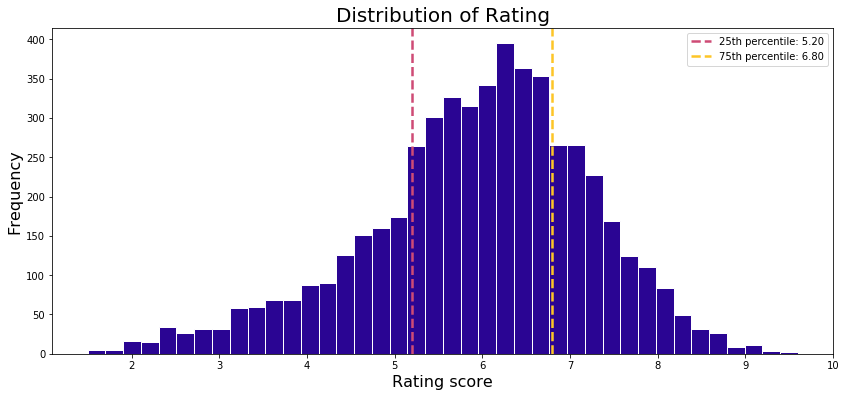

In [13]:
# Plot the histogram using matplotlib
plt.figure(figsize=(14,6))
plt.hist(list(df_movies['Rating'].values), bins=40, edgecolor='white', color=colorpalette[1])
plt.xlabel('Rating score', fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.title('Distribution of Rating', fontsize=20)

# Add vertical lines for mean and median
percentile_25 = np.percentile(list(df_movies['Rating'].values), 25)
percentile_75 = np.percentile(list(df_movies['Rating'].values), 75)
plt.axvline(percentile_25, color=colorpalette[20], linestyle="dashed", linewidth=2.5, label=f"25th percentile: {percentile_25:.2f}")
plt.axvline(percentile_75, color=colorpalette[35], linestyle="dashed", linewidth=2.5, label=f"75th percentile: {percentile_75:.2f}")
    
# Add a legend
plt.legend()
plt.show()

The shown plot illustrates that the distribution of movie rating scores follows a normal distribution, thereby indicating the presence of a statistically representative dataset in terms of rating scores. Furthermore, the 25th and 75th percentiles are shown, serving as the thresholds employed in determining the categorization labelslow*, *moderate* and *high* for the movies.

- Notice this plot *is not used* in the paper.  